_Version log: Finding the best samples though brute force and manual tweaking. Also started to compare different optimisation results._

In [1063]:
import CS_functions as cs
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt, colors as mplcolors
from scipy import fft as spfft
from scipy.constants import speed_of_light as C
plt.rcParams.update({'font.size':24, 'xtick.minor.visible': True, 'ytick.minor.visible': False,
                     'xtick.direction': 'in', 'ytick.direction': 'in', "xtick.top": True, "ytick.right": True,
                     'lines.linewidth': 2.4, 'lines.markersize': 10.0, 'lines.markeredgewidth': 2.4})
#np.set_printoptions(threshold=sys.maxsize)

In [1064]:
file_number = 17 # Use a noiseless version of the interferogram for good convergence
file_name = "1dmockanderrors{:d}".format(file_number)
#file_name = "240802134128_processed1d"

file_type = ".csv"
target, uncertainties = cs.open_dataset(file_name, file_type)
optlocs_file = "data\\" + file_name +"_optlocs.csv"

reduced_points = 4
total_points = len(target)

In [1065]:
full_data = cs.open_csv(optlocs_file, reduced_points)

In [1066]:
test = [ 12,  99, 105, 110] # Manual
#test = cs.subsample_1d(total_points, reduced_points, subsampling_method= "regular") # referance

test = np.array(test)
len(test)

4

In [1067]:
full_data = np.vstack([full_data, test])
full_data.shape

(128, 4)

In [1068]:
regularization_coeffient = 1e-3

def find_error(locations):
    assert locations.ndim == 1
    locations = locations[~np.isnan(locations)].astype(int)

    samples = np.full_like(target, np.nan)
    samples[locations] = target[locations]
    result = cs.compressed_sensing(samples, regularization_coeffient)
    error = np.linalg.norm((target -result) /uncertainties) #This is the chi-squared

    return error

#errors = [find_error(locations) for locations in tqdm(full_data)]
errors = [cs.evaluate_score(locations, target, uncertainties, regularization_coeffient) for locations in tqdm(full_data)]
errors = np.array(errors)


100%|██████████| 128/128 [00:01<00:00, 79.55it/s]


In [1069]:
sort = np.argsort(errors)
print(errors[-1])
#errors = errors[sort]
#full_data = full_data[sort]

5.070964270611931


In [1070]:
print(*zip(errors, full_data), sep= "\n")

(16.751350298186143, array([ 58,  70, 119, 150]))
(15.980770297651667, array([ 76,  83, 122, 170]))
(16.709841691369547, array([110, 115, 118, 167]))
(18.191702435676632, array([  0,  95,  97, 139]))
(19.176099355820643, array([102, 104, 145, 173]))
(18.117026929144675, array([ 95,  97, 110, 198]))
(19.282539552064506, array([  7, 102, 104, 197]))
(18.251043417064448, array([  6,  95,  97, 199]))
(19.005487721801952, array([  1,   8, 102, 104]))
(18.910169074710094, array([ 81, 102, 104, 116]))
(16.616290053987097, array([ 20,  49,  66, 155]))
(16.137095605271913, array([ 43,  66, 121, 188]))
(17.166390956214986, array([ 77, 117, 124, 143]))
(16.334349981656278, array([ 78, 131, 162, 176]))
(17.60295176153851, array([  3, 109, 111, 199]))
(18.494534483102058, array([ 5, 69, 95, 97]))
(19.047800497989897, array([ 68,  95,  97, 174]))
(19.7685257897656, array([ 88,  97, 100, 103]))
(18.86965693764989, array([  6, 102, 104, 199]))
(18.35968098926464, array([  0,  95,  97, 194]))
(18.64712

In [1071]:
sa_error = find_error(test)
brute_errors = np.empty((reduced_points, total_points))

fixed_points = np.repeat(test[None, :], reduced_points, axis= 0)
fixed_points = fixed_points[~np.eye(reduced_points, dtype= bool)] #one of the samples is not fixed
fixed_points = fixed_points.reshape((reduced_points, reduced_points-1)) #tell numpy to stop flattening my array

for n in np.arange(reduced_points):
    trail_samples = np.copy(test)
    for trail_sample in np.arange(total_points):
        trail_samples[n] = trail_sample
        brute_error = find_error(trail_samples) #This is the chi-squared
        brute_errors[n, trail_sample] = brute_error

0.0


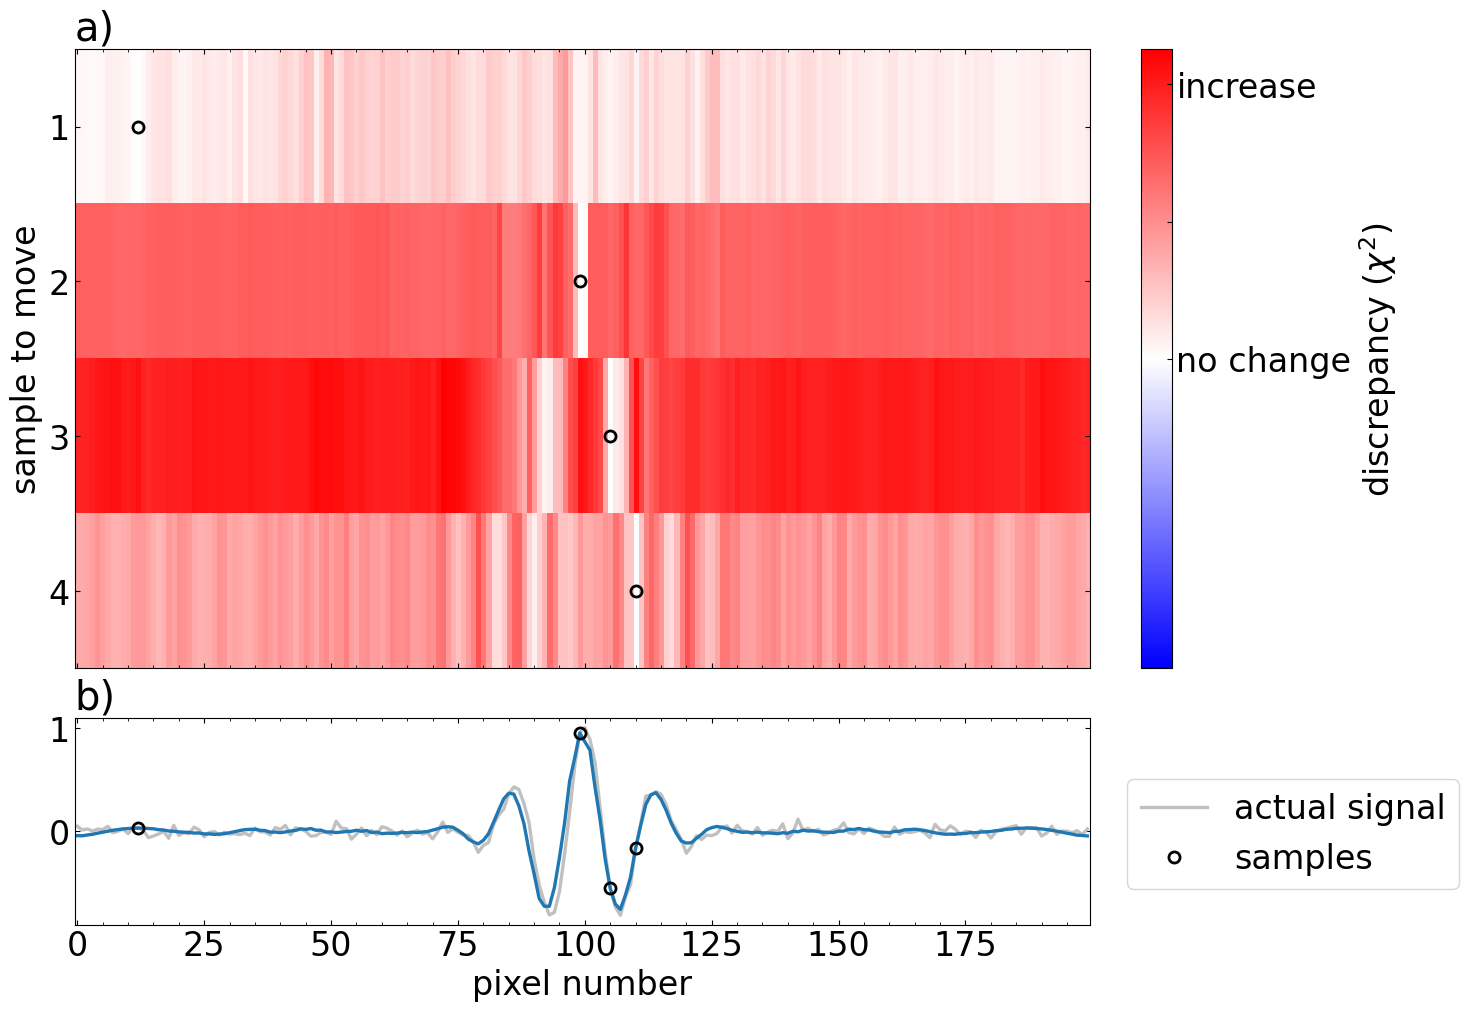

In [1072]:
difference = brute_errors -sa_error

### ticks

max_diff = np.max(difference)
min_diff = np.min(difference)
print(min_diff) # If this is less than zero then SA failed to find the best solution.
if min_diff >= 0: min_diff = -1 #If this is more than or equal to zero then my code breaks!
if max_diff <= 0: max_diff = 1 #If this is less than or equal to zero then my code breaks!

pos_zticks = np.arange(0, max_diff, 10**np.floor(np.log10(np.abs(max_diff))))
neg_zticks = np.arange(0, min_diff, -10**np.floor(np.log10(np.abs(min_diff)))) # np.floor() is NOT the same as int() for negative numbers!
zticks = np.unique(np.concatenate([pos_zticks, neg_zticks]))

zticklabels = np.full_like(zticks, "", dtype= object)
zticklabels[0] = "decrease"
zticklabels[-1] = "increase"
zticklabels[zticks == 0] = "no change"

### colourmap

norm = mplcolors.TwoSlopeNorm(0, vmin=min_diff, vmax=max_diff) #Greatly exagerates the possible improvements

#c, v = ["darkgreen","green","palegreen","white","lightcoral","red","darkred"], [0, 0.1, 0.4, 0.5, 0.6, 0.85, 1.0] # colour, position on scale
#cmap= mplcolors.LinearSegmentedColormap.from_list('rg', list(zip(v,c)), N=256) # very festive! Creates a color scale by interpolating between the specified colours.
cmap= "bwr"

### plot

fig, axs = plt.subplots(2, 1, figsize= (14, 10), sharex= True, height_ratios= (3, 1), layout= "constrained")

im = axs[0].imshow(difference, aspect= "auto", interpolation= "none", cmap= cmap, norm= norm)
cbar = fig.colorbar(im, label= r"discrepancy ($\chi ^2$)")
cbar.set_ticks(ticks= zticks, labels=zticklabels)

axs[0].plot(test ,np.arange(reduced_points), linestyle= "none", marker= "o", color= "black", markerfacecolor= "none", markeredgewidth= 2, markersize= 8) #kind of cursed but it works
axs[0].set(ylabel= "sample to move", yticks= np.arange(reduced_points), yticklabels= np.arange(1, reduced_points+1))
axs[0].set_title("a)", loc= "left")

samples = np.full_like(target, np.nan)
samples[test] = target[test]
test_result = cs.compressed_sensing(samples, regularization_coeffient)

axs[1].plot(target, color= "silver", label= "actual signal")
axs[1].plot(test_result, color= "tab:blue", label= "")
axs[1].plot(test, target[test], linestyle= "none", marker= "o", color= "black", markerfacecolor= "none", markeredgewidth= 2, markersize= 8, label= "samples")
axs[1].set(xlabel= "pixel number")
axs[1].set_title("b)", loc= "left")
plt.figlegend(loc= 'lower right', bbox_to_anchor= (1.05, 0.1))

plt.show()

## COMPARING DIFFERENT RESULTS

In [1073]:
file_name = "240802134128_processed1d"
target, uncertainties = cs.open_dataset(file_name, file_type)
uncertainties /= np.max(target)
target /= np.max(target) # normalise
reduced_points = 8
total_points = len(target)

optimised_detectors = {"Fabricated Schottky Array": [12,16,20,24,28,32,36,40],
                       #"Uniform Sampling": cs.subsample_1d(total_points, reduced_points, "regular"),
                       "Douglas Peucker": [32, 35, 38, 44, 46,  1, 50, 33],
                       "Greedy": [32, 29, 29, 42, 46, 23, 14, 18],
                       "MCMC Metropolis": [12, 14, 16, 29, 31, 32, 42,  4],
                       "Simulated Annealing": [11, 17, 27, 29, 32, 35, 38, 46]}

runtimes = ["1 ms", "200 ms", "1 min", "3 mins", "3 mins", "6 days"]
scores = [cs.evaluate_score(sensors, target, uncertainties, regularization_coeffient) for sensors in optimised_detectors.values()]
print(scores)

pixel_pitch = 1000 #um
theta = 200 #arcminutes # APPOX. NOT MEASURED.

[0.0263308427579126, 0.032150165123981125, 0.02144672498578746, 0.020675547329393553, 0.01979957901018333]


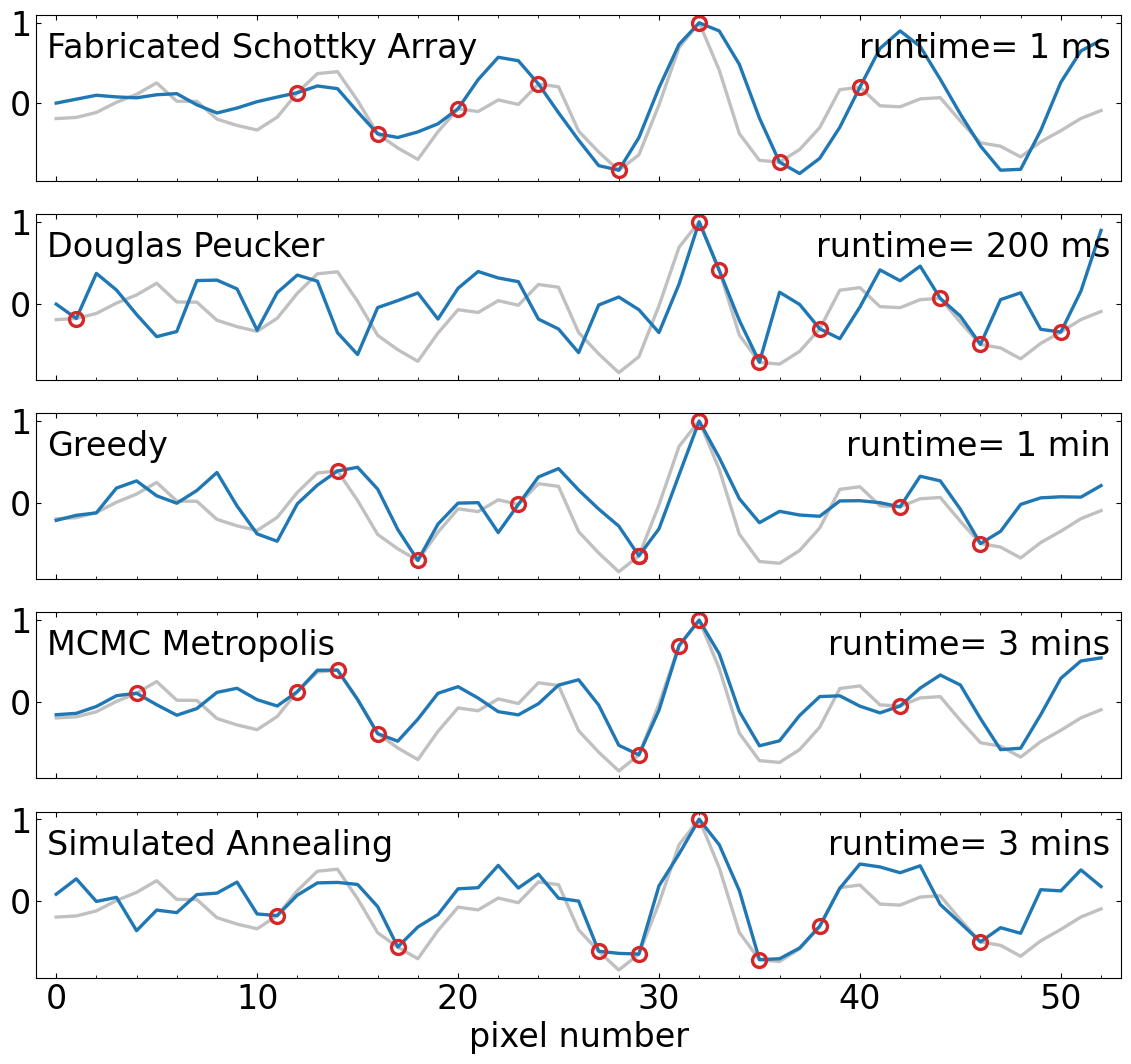

In [1074]:
### INTERFEROGRAMS

number_of_methods = len(optimised_detectors)

fig, axs = plt.subplots(number_of_methods, 1, figsize= (14, 2.5*number_of_methods), sharex= True, gridspec_kw= {"hspace": 0.2}, facecolor='none')

for ax, method, sensors, runtime, score in zip(axs, optimised_detectors.keys(), optimised_detectors.values(), runtimes, scores):
    samples = np.full_like(target, np.nan)
    samples[sensors] = target[sensors]

    result = cs.compressed_sensing(samples, alpha= regularization_coeffient)
    ax.plot(target, color= "silver")
    ax.plot(result)
    ax.plot(sensors, samples[sensors], linestyle= "None", marker= "o", markeredgecolor= "tab:red", markerfacecolor= "None")
    ax.set(xlim= (-1, total_points), facecolor='white')
    ax.annotate(method, (0.01,0.9), xycoords= 'axes fraction', ha= "left", va= "top")
    ax.annotate("runtime= {0:s}".format(runtime), (0.99,0.9), xycoords= 'axes fraction', ha= "right", va= "top")
axs[-1].set(xlabel= "pixel number")

plt.show()

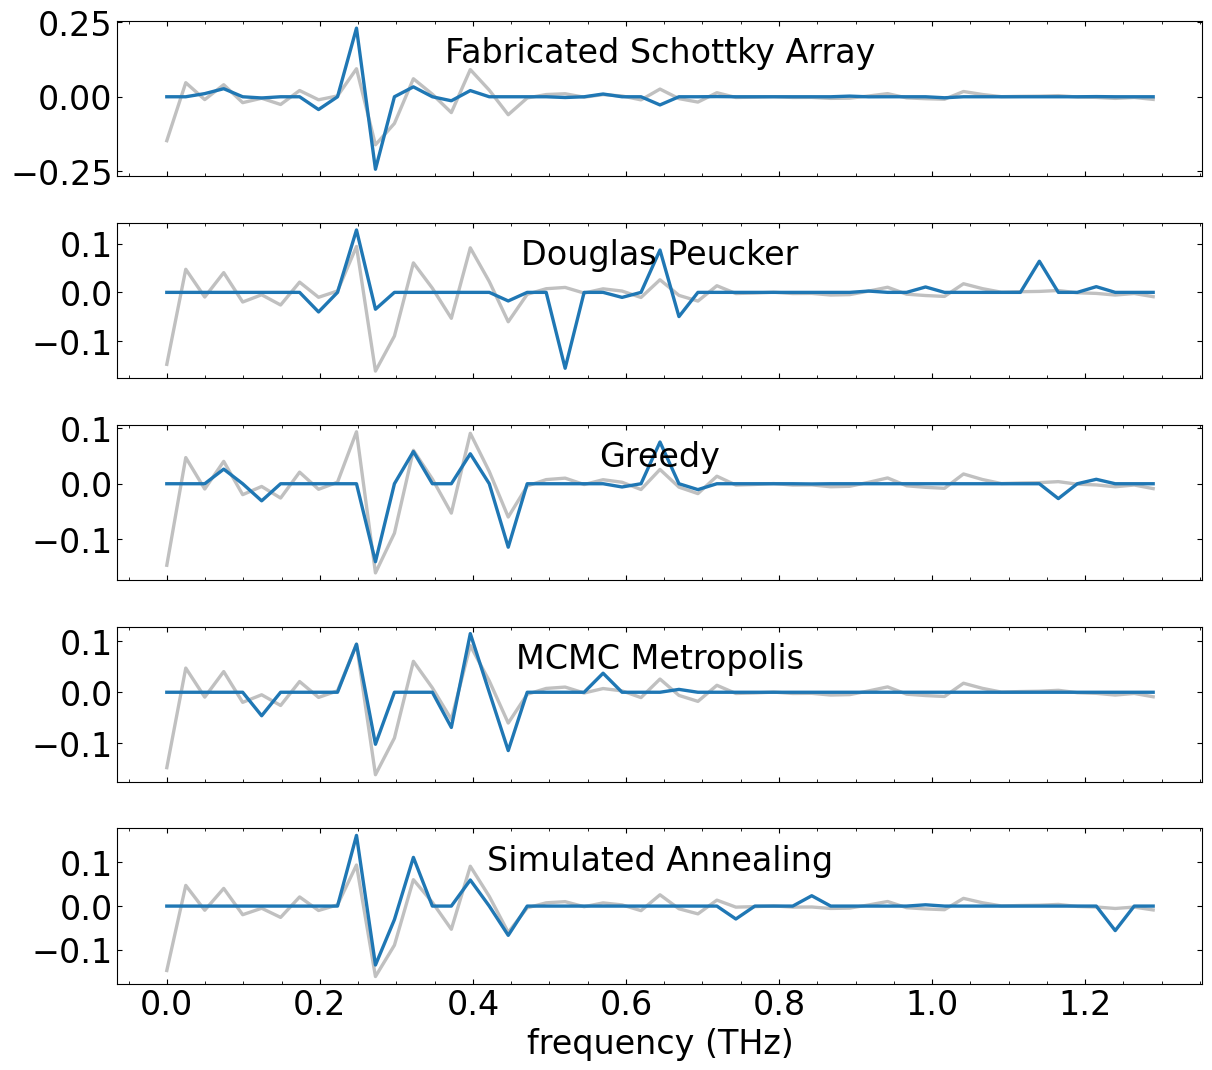

In [1075]:
### DCT BASIS

fig, axs = plt.subplots(number_of_methods, 1, figsize= (14, 2.5*number_of_methods), sharex= True, gridspec_kw= {"hspace": 0.3}, facecolor='none')

nyquist = C / (4 *pixel_pitch*1e-6 *np.sin(np.deg2rad(theta/60)))
nyquist *= 1e-12
freqs = np.linspace(0, nyquist, total_points) # THIS IS APPROXIMATE WHEN TOTAL_POINTS IS ODD.

for ax, method, sensors, runtime, score in zip(axs, optimised_detectors.keys(), optimised_detectors.values(), runtimes, scores):
    samples = np.full_like(target, np.nan)
    samples[sensors] = target[sensors]

    result = cs.compressed_sensing(samples, alpha= regularization_coeffient, domain= "DCT")
    ax.plot(freqs, spfft.dct(target, type= 1, norm= "forward"), color= "silver")
    ax.plot(freqs, result)
    ax.set(facecolor='white')
    ax.annotate(method, (0.5,0.9), xycoords= 'axes fraction', ha= "center", va= "top")
    #ax.annotate("runtime= {0:s}".format(runtime), (0.99,0.9), xycoords= 'axes fraction', ha= "right", va= "top")
axs[-1].set(xlabel= "frequency (THz)")

plt.show()

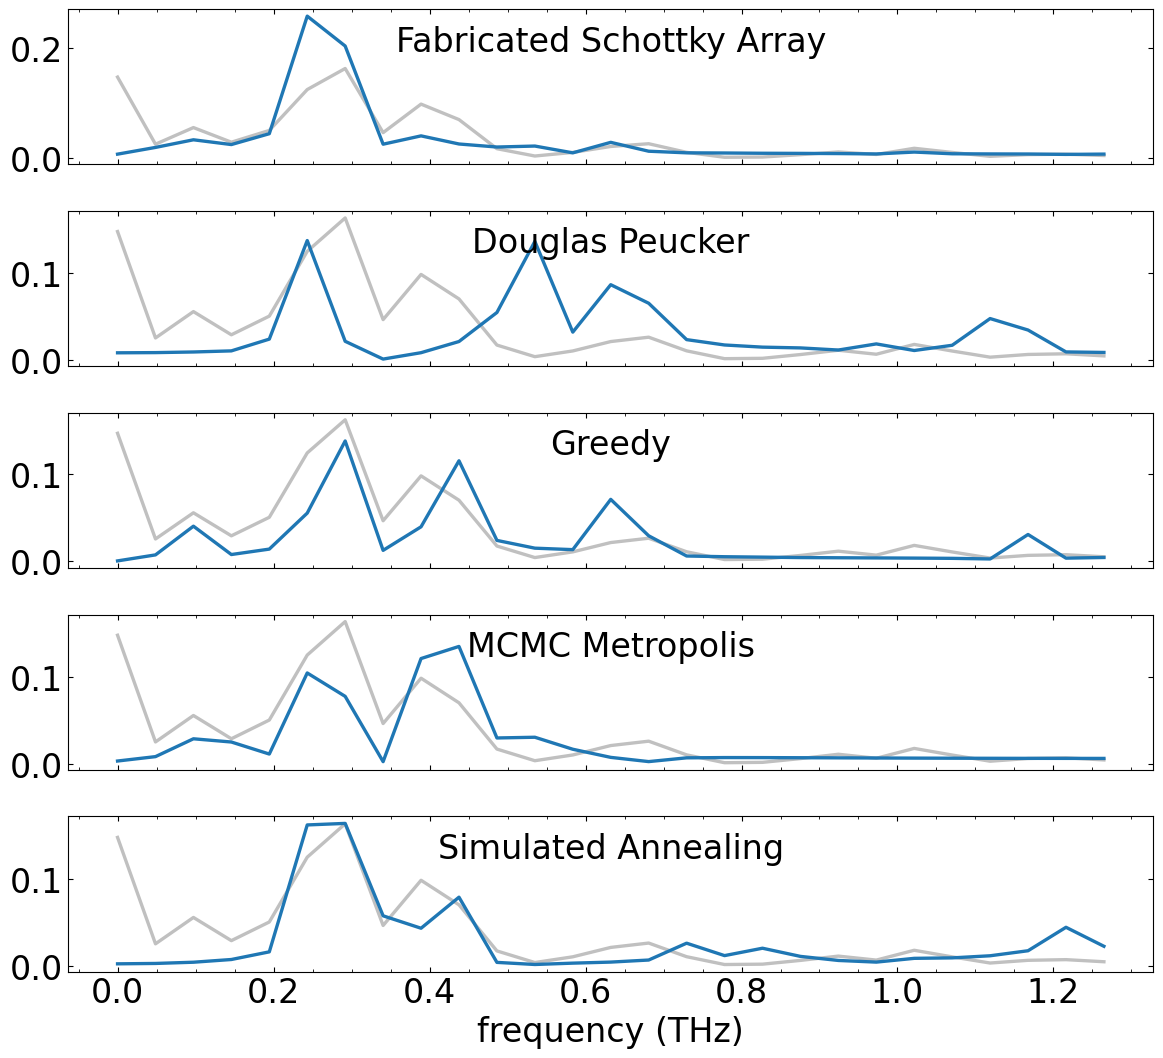

In [1076]:
### POWER SPECTRUM

fig, axs = plt.subplots(number_of_methods, 1, figsize= (14, 2.5*number_of_methods), sharex= True, gridspec_kw= {"hspace": 0.3}, facecolor='none')

freqs = np.fft.rfftfreq(total_points, pixel_pitch*1e-6)
freqs /= 2*np.sin(np.deg2rad(theta/60))
freqs *= C
freqs *= 1e-12

for ax, method, sensors, runtime, score in zip(axs, optimised_detectors.keys(), optimised_detectors.values(), runtimes, scores):
    samples = np.full_like(target, np.nan)
    samples[sensors] = target[sensors]

    result = cs.compressed_sensing(samples, alpha= regularization_coeffient)
    ax.plot(freqs, np.abs(np.fft.rfft(target, norm= "forward")), color= "silver")
    ax.plot(freqs, np.abs(np.fft.rfft(result, norm= "forward")))
    ax.set(facecolor='white')
    ax.annotate(method, (0.5,0.9), xycoords= 'axes fraction', ha= "center", va= "top")
    #ax.annotate("runtime= {0:s}".format(runtime), (0.99,0.9), xycoords= 'axes fraction', ha= "right", va= "top")

axs[-1].set(xlabel= "frequency (THz)")

plt.show()

## GRAPH TO SHOWCASE RESULTS

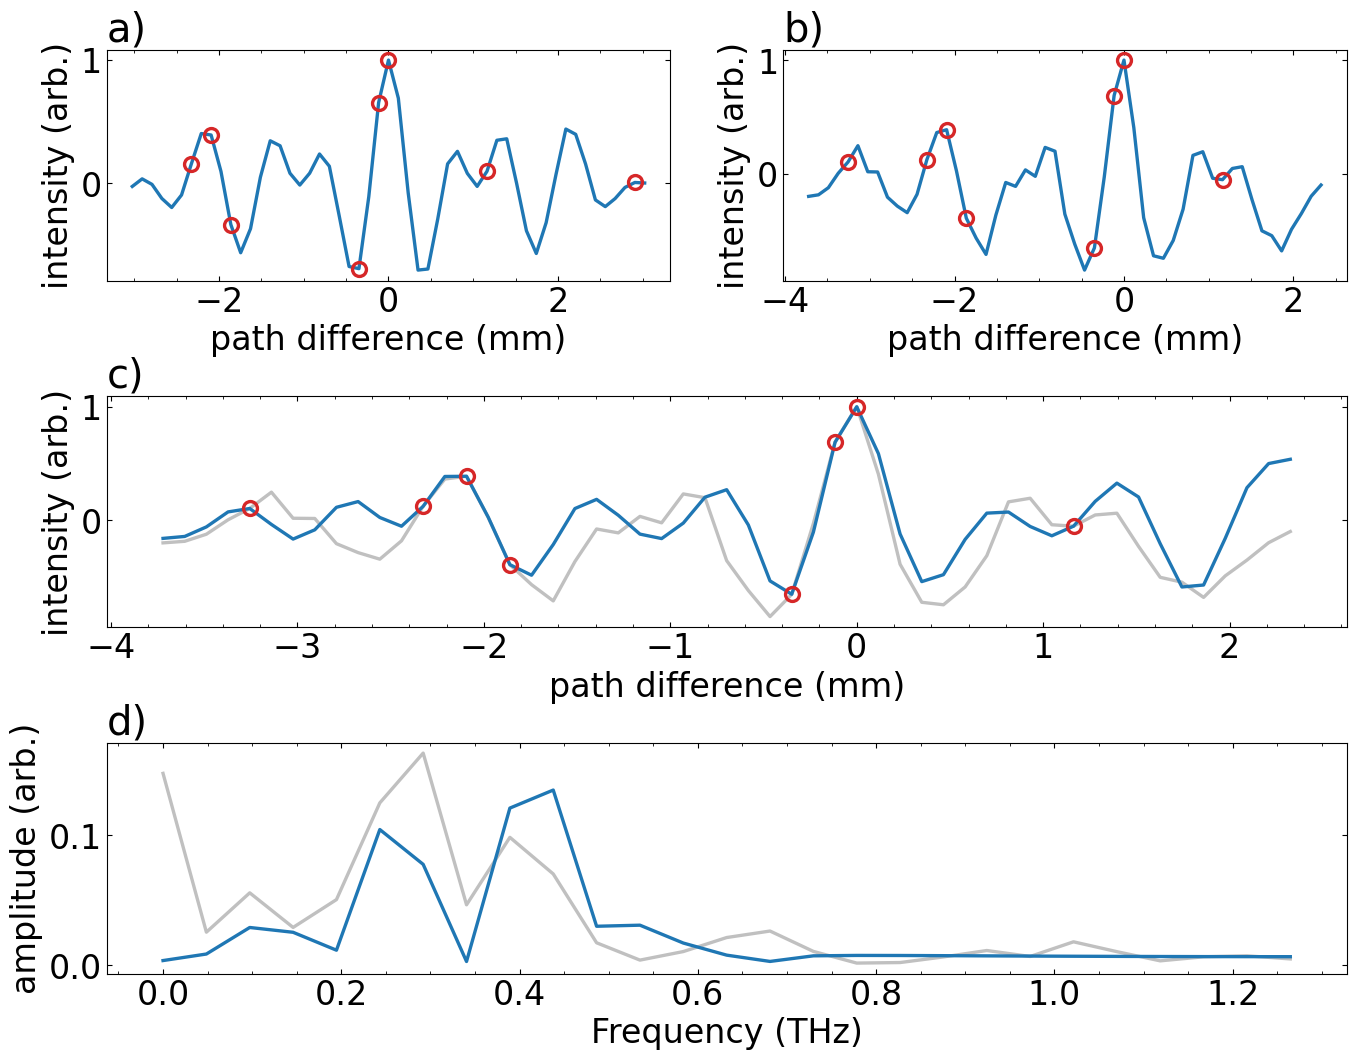

In [1116]:
experiment, _ = cs.open_dataset("240802134128_processed1d", ".csv")
experiment /= np.max(experiment)
simulation, _ = cs.open_dataset("1dmockanderrors22", ".csv")
simulation /= np.max(simulation)

exp_sensors = [12, 14, 16, 29, 31, 32, 42,  4]
sim_sensors = exp_sensors -np.argmax(experiment) +np.argmax(simulation) #recenter
sim_sensors = sim_sensors %total_points #wrap around

samples = np.full_like(target, np.nan)
samples[exp_sensors] = target[exp_sensors]
cs_result = cs.compressed_sensing(samples, alpha= regularization_coeffient, domain= "IDCT")
cs_spectrum = np.abs(np.fft.rfft(cs_result, norm= "forward"))
exp_spectrum = np.abs(np.fft.rfft(experiment, norm= "forward"))

idx = np.arange(total_points)
sim_displacement = pixel_pitch*1e-3 *(idx -np.argmax(simulation)) # in mm
sim_path_difference = 2*sim_displacement*np.sin(np.deg2rad(theta/60))
exp_displacement = pixel_pitch*1e-3 *(idx -np.argmax(experiment)) # in mm
exp_path_difference = 2*exp_displacement*np.sin(np.deg2rad(theta/60))


axs_mosaic = [["a)", "b)"],
              ["c)", "c)"],
              ["d)", "d)"]]

fig, axs = plt.subplot_mosaic(axs_mosaic, figsize= (16,12), gridspec_kw= {"hspace": 0.5})
[ax.set_title(label, loc='left') for label, ax in axs.items()]

axs["a)"].plot(sim_path_difference, simulation)
axs["a)"].plot(sim_path_difference[sim_sensors], simulation[sim_sensors], linestyle= "none", marker= "o", markerfacecolor= "none", markeredgecolor= "tab:red")
axs["a)"].set(xlabel= "path difference (mm)", ylabel= "intensity (arb.)")

axs["b)"].plot(exp_path_difference, experiment)
axs["b)"].plot(exp_path_difference[exp_sensors], experiment[exp_sensors], linestyle= "none", marker= "o", markerfacecolor= "none", markeredgecolor= "tab:red")
axs["b)"].set(xlabel= "path difference (mm)", ylabel= "intensity (arb.)")

axs["c)"].plot(exp_path_difference, experiment, color= "silver")
axs["c)"].plot(exp_path_difference, cs_result, color= "tab:blue")
axs["c)"].plot(exp_path_difference[exp_sensors], experiment[exp_sensors], linestyle= "none", marker= "o", markerfacecolor= "none", markeredgecolor= "tab:red")
axs["c)"].set(xlabel= "path difference (mm)", ylabel= "intensity (arb.)")

axs["d)"].plot(freqs, exp_spectrum, color= "silver")
axs["d)"].plot(freqs, cs_spectrum, color= "tab:blue")
axs["d)"].set(xlabel= "Frequency (THz)", ylabel= "amplitude (arb.)")

plt.show()